Conectado a Python 3.12.3

No se encontraron GPUs disponibles.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\ef.duquevazquez\AppData\Local\Temp\ipykernel_27764\2296812414.py:222: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_parcial])


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


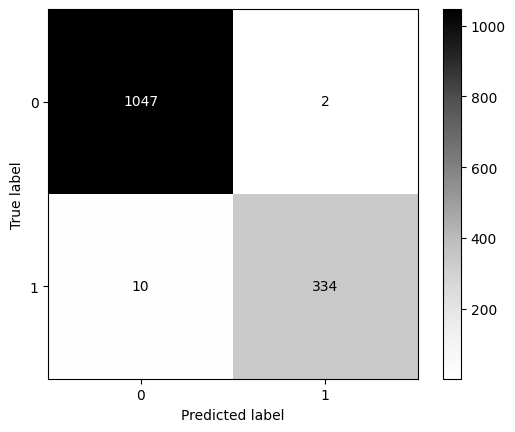

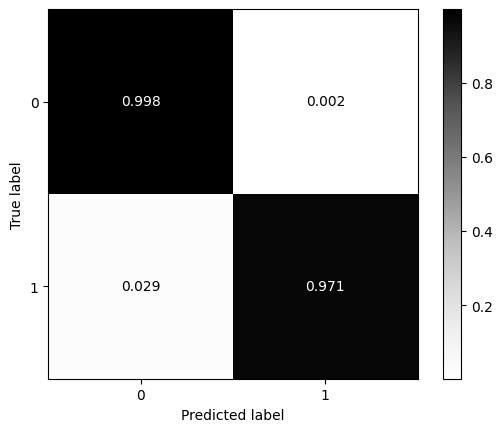

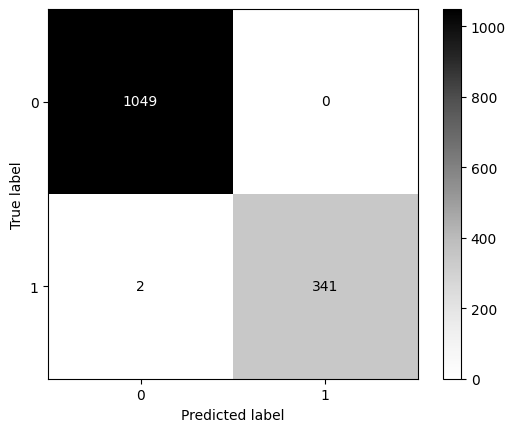

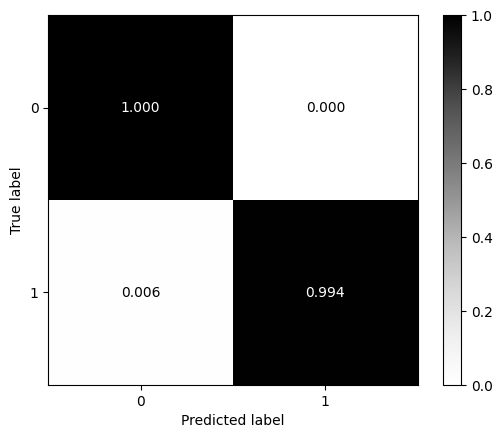

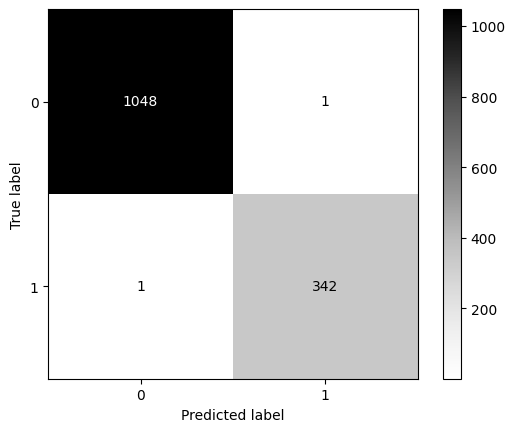

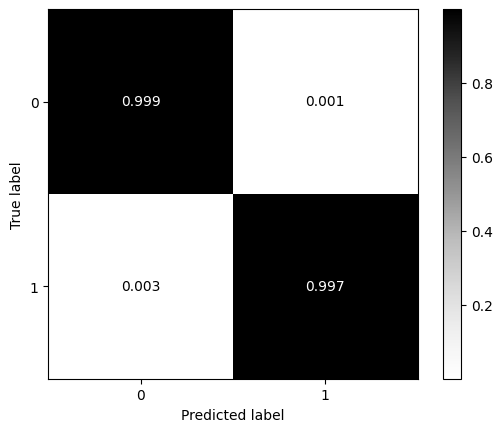

In [6]:
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from keras.models import load_model
from sklearn.metrics import ConfusionMatrixDisplay 
import numpy as np
import tensorflow as tf
from models import CNN_conf1
from models import CNN_conf2
from models import CNN_conf3
from models import CNN_conf5
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU(s) disponibles:", len(gpus))
else:
    print("No se encontraron GPUs disponibles.")


#list_models = [CNN_conf1.base_model(), CNN_conf2.base_model(), CNN_conf3.base_model(), CNN_conf5.base_model()]
#list_models = [CNN_conf2.base_model()]

def normResults(y_pred):
    yp = []
    for row in y_pred:
        valmax = max(row)
        for i in range(len(row)):
            if row[i] == valmax:
                row[i] = 1
            else:
                row[i] = 0
        
        yp.append(row)
    
    return yp

def environment_model_graph(data1, name1, data2, name2, data3, name3, data4, name4, rootsave, nameSave = "graph", var_title="graph", xlabel="Axes X", ylabel="Axes Y"):
    num_epochs = len(data1[0])
    x = [i for i in range(num_epochs)]
    
    y1 = []
    y2 = []
    y3 = []
    y4 = []
    for i,j,m,n in zip(data1[0], data2[0], data3[0], data4[0]):
        y1.append(i)
        y2.append(j)
        y3.append(m)
        y4.append(n)
            
    sns.set(style="darkgrid")
    
    fig, axes = plt.subplots(2,1,figsize=(10,8))
    
    axes[0].plot(x, y1, label=name1)
    axes[0].plot(x, y2, label=name2)
    axes[0].set_title(var_title)
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)
    axes[0].legend()
    
    axes[1].plot(x, y3, label=name3)
    axes[1].plot(x, y4, label=name4)
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel(ylabel)
    axes[1].legend()
    
    plt.tight_layout()
    
    name = nameSave+'.png'
    plt.savefig(rootsave+name, dpi=300)


def add_column_df(df, kfold,precision, recall, f1_list, weighted_avg):
    
    df['kfold'] = [kfold, kfold]
    df['class'] = [0,1]
    df['precision'] = precision
    df['recall'] = recall
    df['f1'] = f1_list
    df['weighted_avg'] = [weighted_avg, weighted_avg]
    
    return df


"""Paths and data"""
root = '../results/'
root_graphs = root+'figures/'
#load data
data = np.load("../dataset/crops/dataset.npy")
labels = np.load("../dataset/crops/labels.npy")

data = data/255.0


""" Train and test """
skfolds = StratifiedKFold(n_splits=3)

no_model = 2
#for model in list_models:

columns = ['kfold', 'phase', 'precision', 'recall', 'f1', 'weighted_avg']
df = pd.DataFrame(columns=columns)
df_parcial = pd.DataFrame(columns=columns)
num_fold = 0
for train_index, test_index in skfolds.split(data, labels):
            
    #divide data
    X_train_folds = data[train_index]
    y_train_folds = labels[train_index]
    X_test_folds  = data[test_index]
    y_test_folds  = labels[test_index]
        
    
    y_train_folds = to_categorical(y_train_folds)
    y_test_folds = to_categorical(y_test_folds)
    
    """ train"""
    #define callback EarlyStopping
    #early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, restore_best_weights=True)
    #fit model
    #history = model.fit(X_train_folds, y_train_folds, validation_data = (X_test_folds, y_test_folds), epochs=200, batch_size=16, callbacks=[early_stopping])

    model = load_model('../results/models/model_CNN_0_2.h5')
        
    name_model = 'model_CNN_' + str(num_fold) + '_' + str(no_model)
    model.save(root+'models/'+name_model+'.h5')

    #accuracy = []
    #loss = []
    #val_accuracy = []                                                      
    #val_loss = []
    #accuracy_model = []

    #accuracy.append(history.history['accuracy'])
    #loss.append(history.history['loss'])
    #val_accuracy.append(history.history['val_accuracy'])
    #val_loss.append(history.history['val_loss'])

    #name_graph = 'model_CNN_' + str(num_fold) + '_' + str(no_model) + '_' + 'val_and_loss'
    """ environment_model_graph(accuracy, 
                            'Training Accuracy', 
                            val_accuracy, 
                            'Validation Accuracy', 
                            loss, 
                            'Training Loss', 
                            val_loss, 
                            'Validation Loss', 
                            root_graphs, 
                            name_graph, 
                            var_title="Training and Validation", 
                            xlabel="epochs", 
                            ylabel="") """ 

    #accuracy_model.append(model.evaluate(X_test_folds, y_test_folds))
    y_pred = model.predict(X_test_folds)

    ypred_cm = []
    y_test_folds_cm = []
    for i in range(len(y_pred)):
        ypred_cm.append(np.argmax(y_pred[i]))
        y_test_folds_cm.append(np.argmax(y_test_folds[i]))

    yp = [] 
    yp = normResults(y_pred)

    results = []
    n_correct = sum(yp == y_test_folds)
    results.append(n_correct/len(y_pred))
    
    rootcm = root_graphs+"cm/cm_"
    nameimg = "Confusion matrix" 
    cm_display = ConfusionMatrixDisplay.from_predictions(y_test_folds_cm,ypred_cm, cmap=plt.cm.Greys)
    fig, ax = plt.subplots()
    cm_display.plot(ax=ax)

    plt.grid(visible=False)
    plt.title(nameimg)
    plt.savefig(rootcm + str(num_fold) + '_' + str(no_model) + '.png')
    plt.close()

    cm_display = ConfusionMatrixDisplay.from_predictions(y_test_folds_cm,ypred_cm, cmap=plt.cm.Greys, normalize="true", values_format = ".3f")
    fig, ax = plt.subplots()
    cm_display.plot(ax=ax)

    plt.grid(visible=False)
    plt.title(nameimg)
    plt.savefig(rootcm + str(num_fold) + '_norm_' + str(no_model) + '.png')
    plt.close()


    yp2 = np.array(yp)
    precision = []
    recall = []
    f1_list = []
    for i in range(2):
        precision.append(precision_score(y_test_folds[:,i],yp2[:,i]))
        recall.append(recall_score(y_test_folds[:,i],yp2[:,i]))
        f1 = f1_score(y_test_folds[:,i],yp2[:,i])
        f1_list.append(f1)

    weighted_avg = []
    f1_list = np.array(f1_list)    
    weight = np.array(list(sum(y_test_folds == 1)))
    weighted_sum = np.sum(f1_list * weight)
    total_weight = np.sum(weight)
    weighted_avg.append(weighted_sum / total_weight)

    df_parcial = add_column_df(df_parcial,num_fold, precision, recall, f1_list, weighted_sum / total_weight)
    num_fold += 1
    
    df = pd.concat([df, df_parcial])

    #root_df = root+"sheets/"
    #name_excel = "result_model_" + str(no_model) + ".xlsx"
    #df.to_excel(root_df + name_excel, index=False)
    no_model += 1        